In [3]:
from analysis import analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from copy import deepcopy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [4]:
company_name = 'ITC'
analyse = analysis(company_name)
share_price_arr = analyse.share_price_range('4y', '1d')
for price in share_price_arr:
    print(price)

{'Date': '2021-03-15', 'Close': 178.06}
{'Date': '2021-03-16', 'Close': 180.14}
{'Date': '2021-03-17', 'Close': 182.52}
{'Date': '2021-03-18', 'Close': 188.64}
{'Date': '2021-03-19', 'Close': 193.23}
{'Date': '2021-03-22', 'Close': 195.87}
{'Date': '2021-03-23', 'Close': 192.58}
{'Date': '2021-03-24', 'Close': 187.16}
{'Date': '2021-03-25', 'Close': 183.39}
{'Date': '2021-03-26', 'Close': 182.78}
{'Date': '2021-03-30', 'Close': 185.95}
{'Date': '2021-03-31', 'Close': 189.37}
{'Date': '2021-04-01', 'Close': 190.72}
{'Date': '2021-04-05', 'Close': 184.21}
{'Date': '2021-04-06', 'Close': 184.3}
{'Date': '2021-04-07', 'Close': 185.3}
{'Date': '2021-04-08', 'Close': 184.82}
{'Date': '2021-04-09', 'Close': 184.69}
{'Date': '2021-04-12', 'Close': 177.93}
{'Date': '2021-04-13', 'Close': 180.88}
{'Date': '2021-04-15', 'Close': 179.14}
{'Date': '2021-04-16', 'Close': 180.23}
{'Date': '2021-04-19', 'Close': 178.19}
{'Date': '2021-04-20', 'Close': 176.41}
{'Date': '2021-04-22', 'Close': 178.45}
{'

In [5]:
share_price_df = pd.DataFrame(share_price_arr)

def str_to_datetime(str_date):
    str_date_splite = str_date.split('-')
    year, month, day = int(str_date_splite[0]), int(str_date_splite[1]), int(str_date_splite[2])
    return datetime.datetime(year=year, month=month, day=day)

share_price_df['Date'] = share_price_df['Date'].apply(str_to_datetime)
share_price_df.index = share_price_df.pop('Date')
print(share_price_df)

             Close
Date              
2021-03-15  178.06
2021-03-16  180.14
2021-03-17  182.52
2021-03-18  188.64
2021-03-19  193.23
...            ...
2025-03-07  403.90
2025-03-10  405.00
2025-03-11  406.20
2025-03-12  412.40
2025-03-13  412.05

[990 rows x 1 columns]


Text(0, 0.5, 'Price')

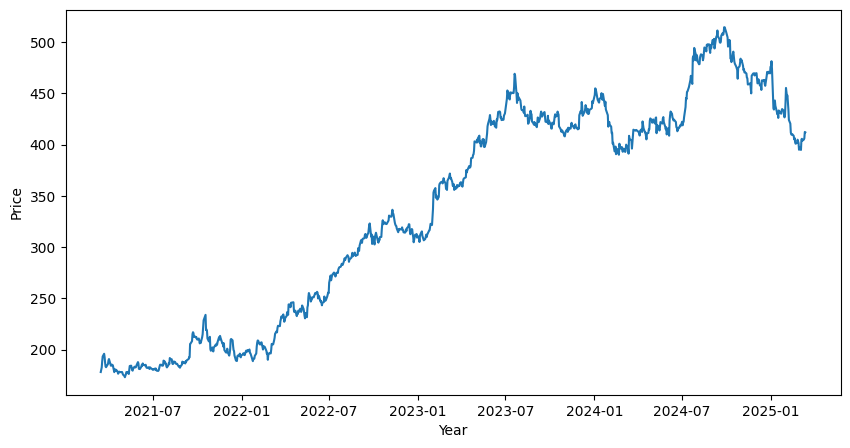

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(share_price_df.index, share_price_df['Close'])
plt.xlabel('Year')
plt.ylabel('Price')


In [12]:
def df_to_windowed_df(dateframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    x_train, y_train = [], []

    last_time = False

    while True:
        df_subset = dateframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x_train_data, y_train_data = values[:-1], values[-1]

        dates.append(target_date)
        x_train.append(x_train_data)
        y_train.append(y_train_data)

        next_week = dateframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    x_train = np.array(x_train)

    for i in range(0, n):
        x_train[:, i]
        ret_df[f'Target-{n-i}'] = x_train[:, i]
    
    ret_df['Target'] = y_train

    return ret_df


windowed_df = df_to_windowed_df(share_price_df, '2022-03-07', '2025-03-13', n=3)
print(windowed_df)

    Target Date  Target-3  Target-2  Target-1  Target
0    2022-03-07    196.22    199.96    205.52  205.01
1    2022-03-08    199.96    205.52    205.01  206.79
2    2022-03-09    205.52    205.01    206.79  208.93
3    2022-03-10    205.01    206.79    208.93  211.44
4    2022-03-11    206.79    208.93    211.44  215.40
..          ...       ...       ...       ...     ...
743  2025-03-07    394.85    405.05    405.70  403.90
744  2025-03-10    405.05    405.70    403.90  405.00
745  2025-03-11    405.70    403.90    405.00  406.20
746  2025-03-12    403.90    405.00    406.20  412.40
747  2025-03-13    405.00    406.20    412.40  412.05

[748 rows x 5 columns]


In [13]:
def windowed_df_to_x_train_y_train(windowed_dateframe):
    df_as_np = windowed_dateframe.to_numpy()
    
    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    x_train = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    y_train = df_as_np[:, -1]

    return dates, x_train.astype(np.float32), y_train.astype(np.float32)

dates, x_data, y_data = windowed_df_to_x_train_y_train(windowed_df)

dates.shape, x_data.shape, y_data.shape

((748,), (748, 3, 1), (748,))

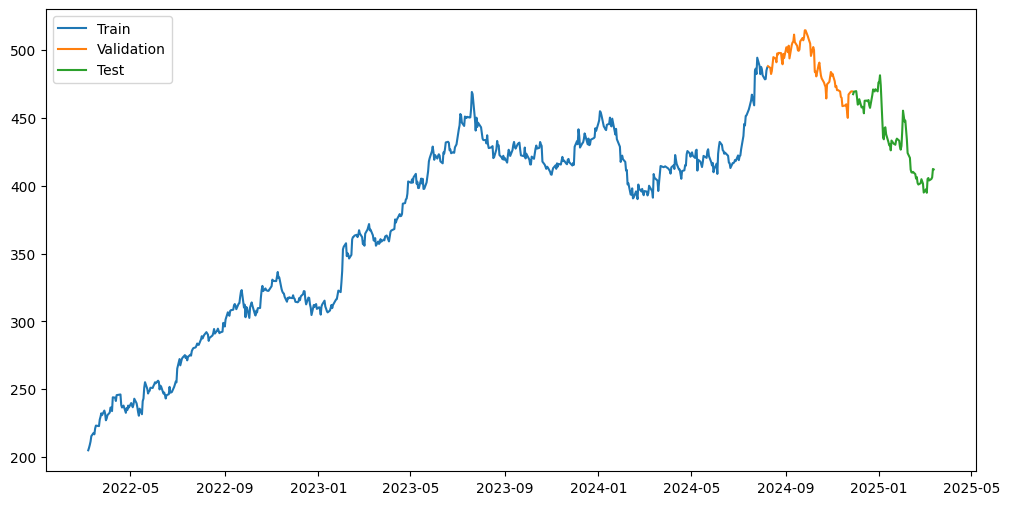

In [18]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], x_data[:q_80], y_data[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], x_data[q_80:q_90], y_data[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], x_data[q_90:], y_data[q_90:]

plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])


In [19]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
19/19 [==============================] - 11s 135ms/step - loss: 139070.9844 - mean_absolute_error: 365.8702 - val_loss: 238323.9531 - val_mean_absolute_error: 487.9367
Epoch 2/100
19/19 [==============================] - 0s 17ms/step - loss: 138567.6875 - mean_absolute_error: 365.1833 - val_loss: 237453.4688 - val_mean_absolute_error: 487.0438
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 137295.7969 - mean_absolute_error: 363.4395 - val_loss: 234863.5156 - val_mean_absolute_error: 484.3777
Epoch 4/100
19/19 [==============================] - 0s 18ms/step - loss: 134342.1406 - mean_absolute_error: 359.3251 - val_loss: 228401.1406 - val_mean_absolute_error: 477.6599
Epoch 5/100
19/19 [==============================] - 0s 18ms/step - loss: 126968.9375 - mean_absolute_error: 348.9328 - val_loss: 214362.0312 - val_mean_absolute_error: 462.7313
Epoch 6/100
19/19 [==============================] - 0s 17ms/step - loss: 114187.3594 - mean_absolute_error:

19/19 [==============================] - 0s 6ms/step


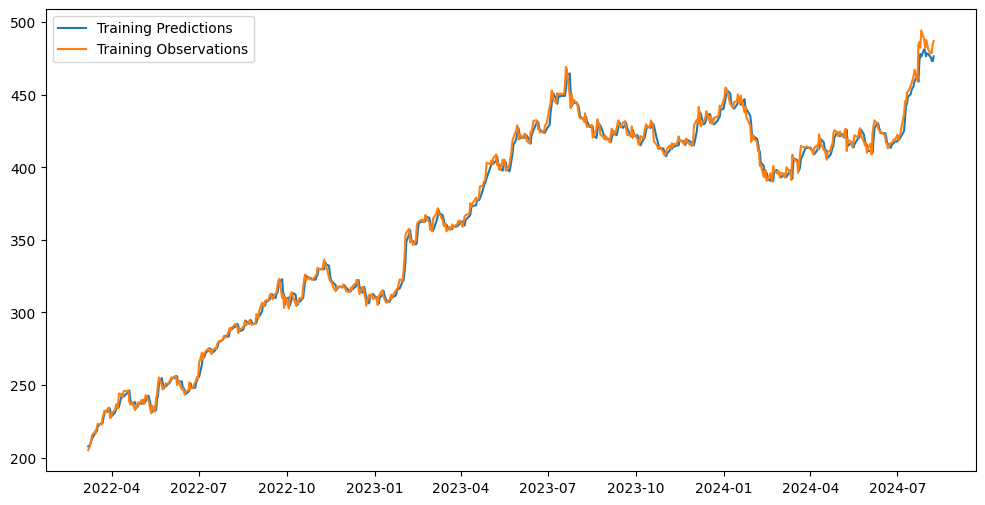

In [21]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 7ms/step


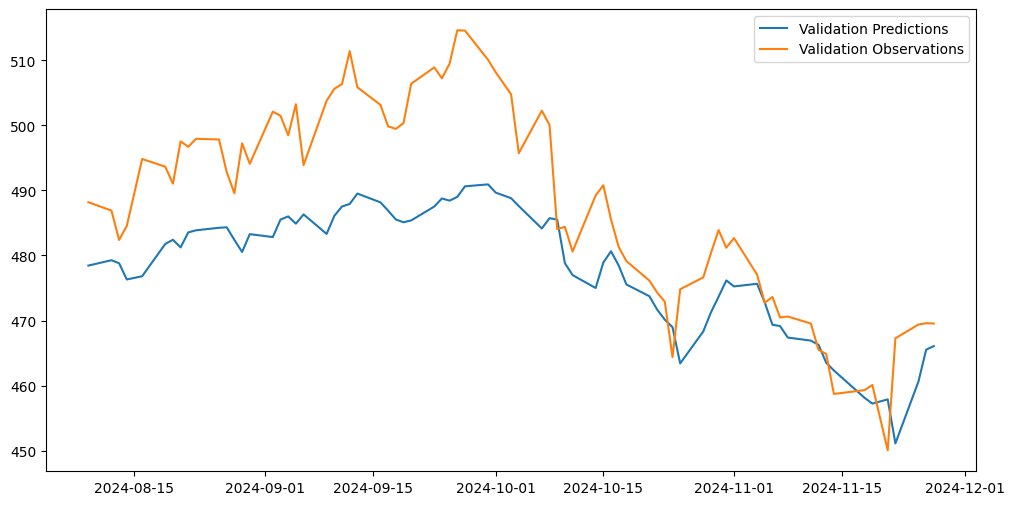

In [22]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(12, 6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 7ms/step


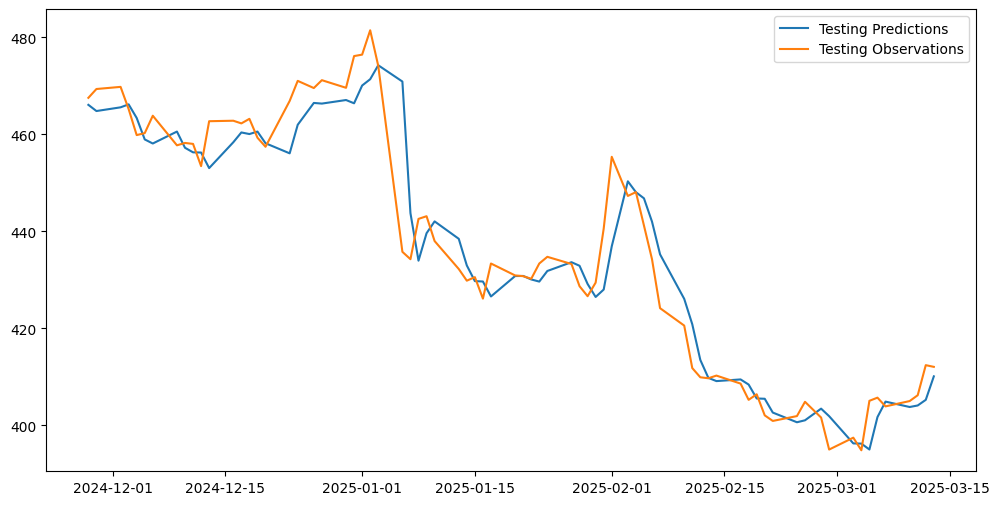

In [24]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

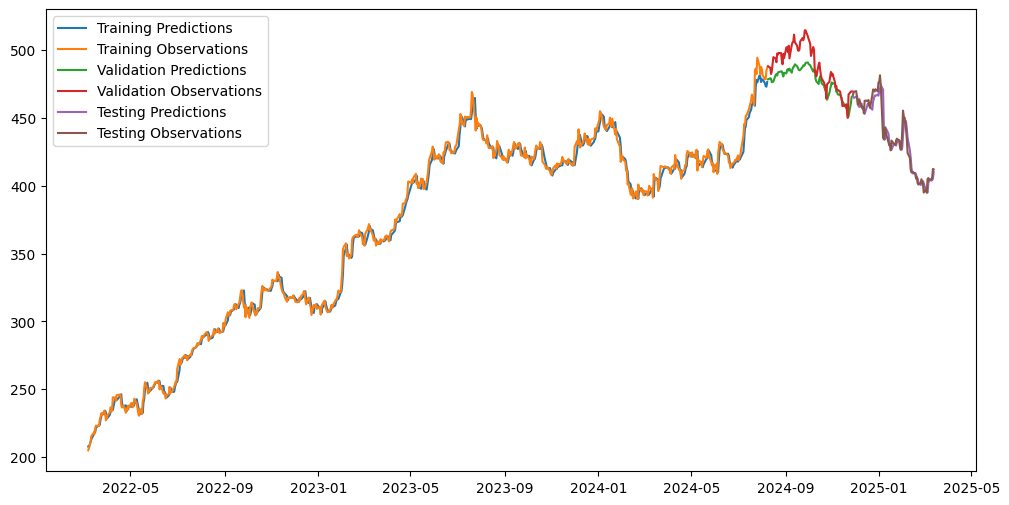

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

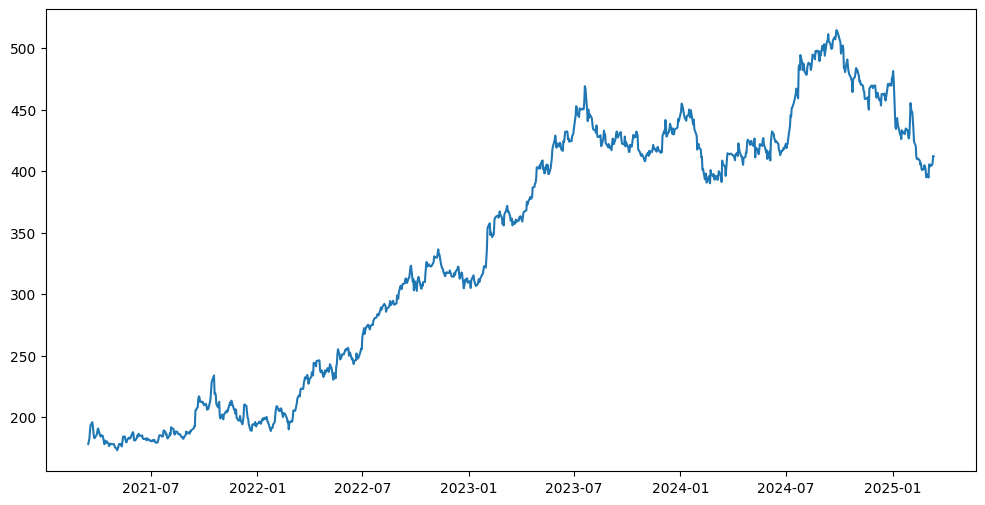

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(share_price_df.index, share_price_df['Close'])